In [1]:
import sys

sys.path.append("../")

import Library.Utility as utility
import Library.AdamWR.adamw as adamw
import Library.AdamWR.cyclic_scheduler as cyclic_scheduler

import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
load = "Data"
gating_indices = torch.tensor([(2486 + i) for i in range(130)])
main_indices = torch.tensor([(0 + i) for i in range(2486)])

save = "./Training"

# InputFile = load + "/Input.bin"
# OutputFile = load + "/Output.bin"
InputFile = load + "/Input.txt"
OutputFile = load + "/Output.txt"
# InputFile = utility.ReadBinary(InputFile, sample_count, input_dim)
# OutputFile = utility.ReadBinary(OutputFile, sample_count, output_dim)
Xshape = utility.LoadTxtAsInt(load + "/InputShape.txt", True)
Yshape = utility.LoadTxtAsInt(load + "/OutputShape.txt", True)
Xnorm = utility.LoadTxt(load + "/InputNormalization.txt", True)
Ynorm = utility.LoadTxt(load + "/OutputNormalization.txt", True)


Loading Data/InputShape.txt
Loading Data/OutputShape.txt
Loading Data/InputNormalization.txt
Loading Data/OutputNormalization.txt


In [3]:
def load_labels(path):
    with open(path, "r") as file:
        labels = [line.strip().split(" ")[1] for line in file.readlines()]
    return labels

In [4]:
X_Labels = load_labels(load + "/InputLabels.txt")
print(np.shape(X_Labels))

# X_Labels

(2616,)


In [31]:
Input_Phase_Labels = np.array(X_Labels)[gating_indices]
Input_Phase_Labels

array(['PhaseSpace-1', 'PhaseSpace-2', 'PhaseSpace-3', 'PhaseSpace-4',
       'PhaseSpace-5', 'PhaseSpace-6', 'PhaseSpace-7', 'PhaseSpace-8',
       'PhaseSpace-9', 'PhaseSpace-10', 'PhaseSpace-11', 'PhaseSpace-12',
       'PhaseSpace-13', 'PhaseSpace-14', 'PhaseSpace-15', 'PhaseSpace-16',
       'PhaseSpace-17', 'PhaseSpace-18', 'PhaseSpace-19', 'PhaseSpace-20',
       'PhaseSpace-21', 'PhaseSpace-22', 'PhaseSpace-23', 'PhaseSpace-24',
       'PhaseSpace-25', 'PhaseSpace-26', 'PhaseSpace-27', 'PhaseSpace-28',
       'PhaseSpace-29', 'PhaseSpace-30', 'PhaseSpace-31', 'PhaseSpace-32',
       'PhaseSpace-33', 'PhaseSpace-34', 'PhaseSpace-35', 'PhaseSpace-36',
       'PhaseSpace-37', 'PhaseSpace-38', 'PhaseSpace-39', 'PhaseSpace-40',
       'PhaseSpace-41', 'PhaseSpace-42', 'PhaseSpace-43', 'PhaseSpace-44',
       'PhaseSpace-45', 'PhaseSpace-46', 'PhaseSpace-47', 'PhaseSpace-48',
       'PhaseSpace-49', 'PhaseSpace-50', 'PhaseSpace-51', 'PhaseSpace-52',
       'PhaseSpace-53', 'PhaseSpac

In [6]:
output_phase_indices = torch.tensor([(943 + i) for i in range(140)])

Y_Labels = load_labels(load + "/OutputLabels.txt")

Output_Phase_Labels =  np.array(Y_Labels)[output_phase_indices]
Output_Phase_Labels

array(['PhaseUpdate-1', 'PhaseUpdate-2', 'PhaseUpdate-3', 'PhaseUpdate-4',
       'PhaseUpdate-5', 'PhaseUpdate-6', 'PhaseUpdate-7', 'PhaseUpdate-8',
       'PhaseUpdate-9', 'PhaseUpdate-10', 'PhaseUpdate-11',
       'PhaseUpdate-12', 'PhaseUpdate-13', 'PhaseUpdate-14',
       'PhaseUpdate-15', 'PhaseUpdate-16', 'PhaseUpdate-17',
       'PhaseUpdate-18', 'PhaseUpdate-19', 'PhaseUpdate-20',
       'PhaseUpdate-21', 'PhaseUpdate-22', 'PhaseUpdate-23',
       'PhaseUpdate-24', 'PhaseUpdate-25', 'PhaseUpdate-26',
       'PhaseUpdate-27', 'PhaseUpdate-28', 'PhaseUpdate-29',
       'PhaseUpdate-30', 'PhaseUpdate-31', 'PhaseUpdate-32',
       'PhaseUpdate-33', 'PhaseUpdate-34', 'PhaseUpdate-35',
       'PhaseUpdate-36', 'PhaseUpdate-37', 'PhaseUpdate-38',
       'PhaseUpdate-39', 'PhaseUpdate-40', 'PhaseUpdate-41',
       'PhaseUpdate-42', 'PhaseUpdate-43', 'PhaseUpdate-44',
       'PhaseUpdate-45', 'PhaseUpdate-46', 'PhaseUpdate-47',
       'PhaseUpdate-48', 'PhaseUpdate-49', 'PhaseUpdate-50

In [7]:
Input_Phase_Labels = np.array(X_Labels)[gating_indices]
np.shape(Input_Phase_Labels)

(130,)

## Param

In [8]:
utility.SetSeed(23456)

epochs = 10 # 150
batch_size = 3200
dropout = 0.3
gating_hidden = 64
main_hidden = 1024
experts = 8

learning_rate = 1e-4
weight_decay = 1e-4
restart_period = 10
restart_mult = 2

sample_count = Xshape[0]
input_dim = Xshape[1]
output_dim = Yshape[1]

In [9]:
I = np.arange(sample_count)
i = 0

In [10]:
train_indices = I[i:i + batch_size]

xBatch = utility.ReadBatchFromFile(InputFile, train_indices, input_dim)
yBatch = utility.ReadBatchFromFile(OutputFile, train_indices, output_dim)

In [11]:
xBatch.shape

torch.Size([3200, 2616])

In [12]:
yBatch.shape

torch.Size([3200, 1083])

In [13]:
Xnorm.shape

(2, 2616)

In [14]:
Ynorm.shape

(2, 1083)

In [15]:
g = xBatch[:, gating_indices]
g.shape

torch.Size([3200, 130])

In [20]:
m = xBatch[:, main_indices]
m.shape

torch.Size([3200, 2486])

In [36]:
def visualize_data(data, labels):
    # Assuming data is of shape (lines, timestamps), where timestamps is the x-axis
    num_lines, num_timestamps = data.shape

    # Create a figure for plotting
    plt.figure(figsize=(20, 10))

    # Plot each line across the timestamps
    for i in range(num_lines):
        plt.plot(range(num_timestamps), data[i], label=labels[i])

    plt.title('Line Visualization over Time')
    plt.xlabel('Timestamps')
    plt.ylabel('Values')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1, fontsize='small')
    plt.show()


In [34]:
# np.shape(Input_Phase_Labels)
np.shape(g)

torch.Size([3200, 130])

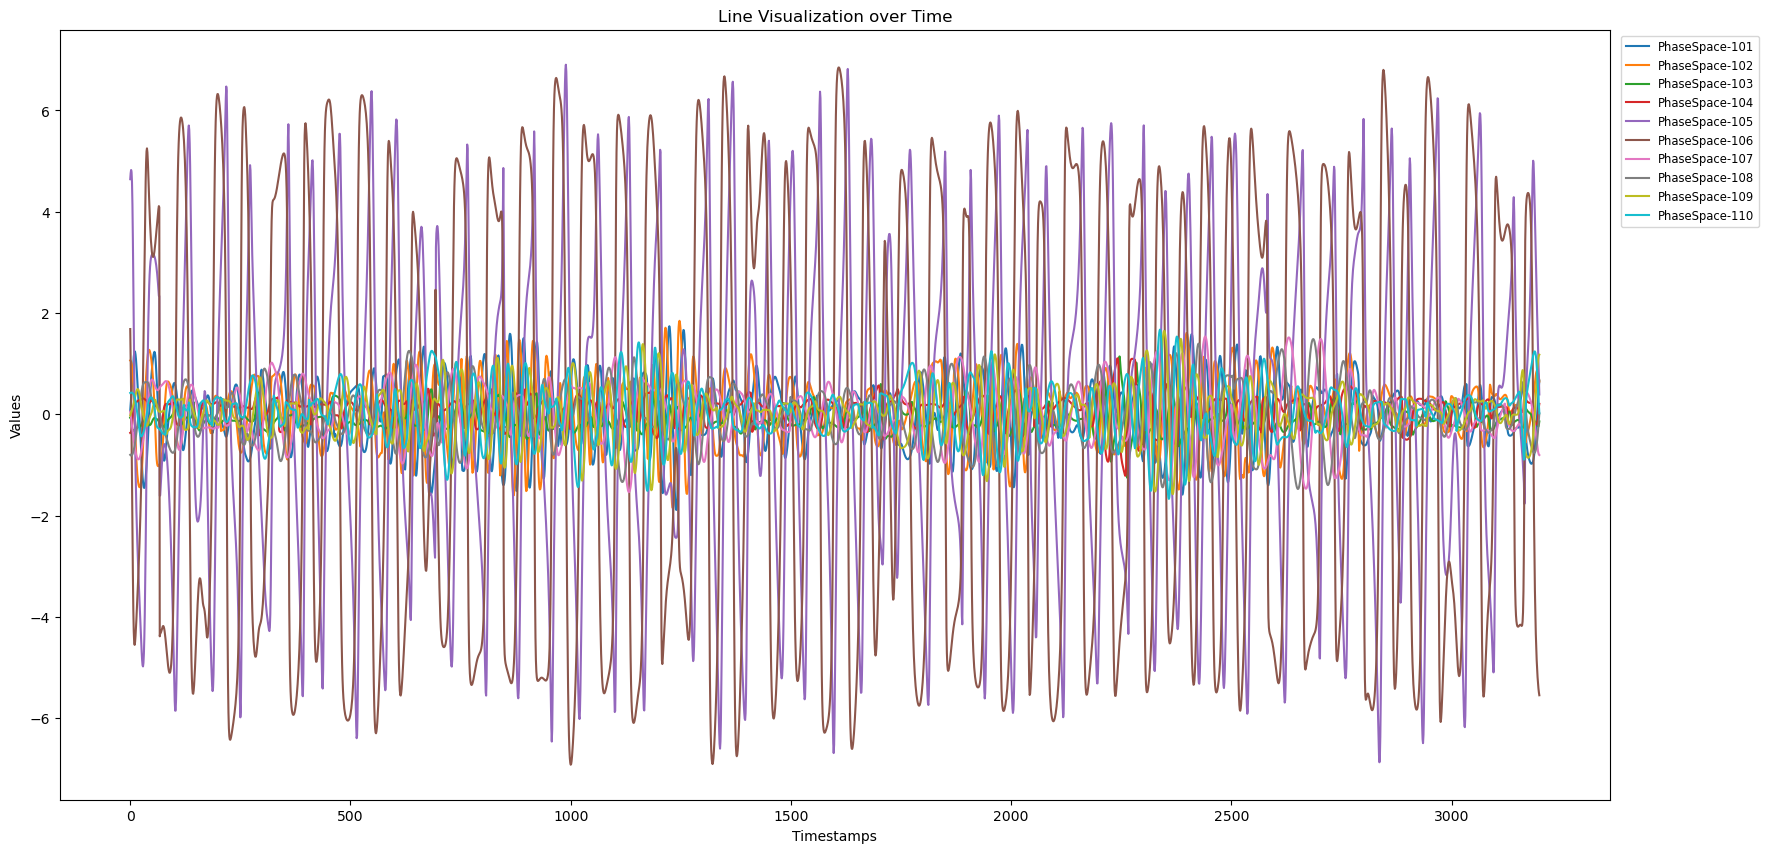

In [41]:
visualize_data(g[:, 100:110].cpu().T, Input_Phase_Labels[100:110])

In [69]:
output_phase_series = yBatch[:, output_phase_indices]
np.shape(output_phase_series)

torch.Size([3200, 140])

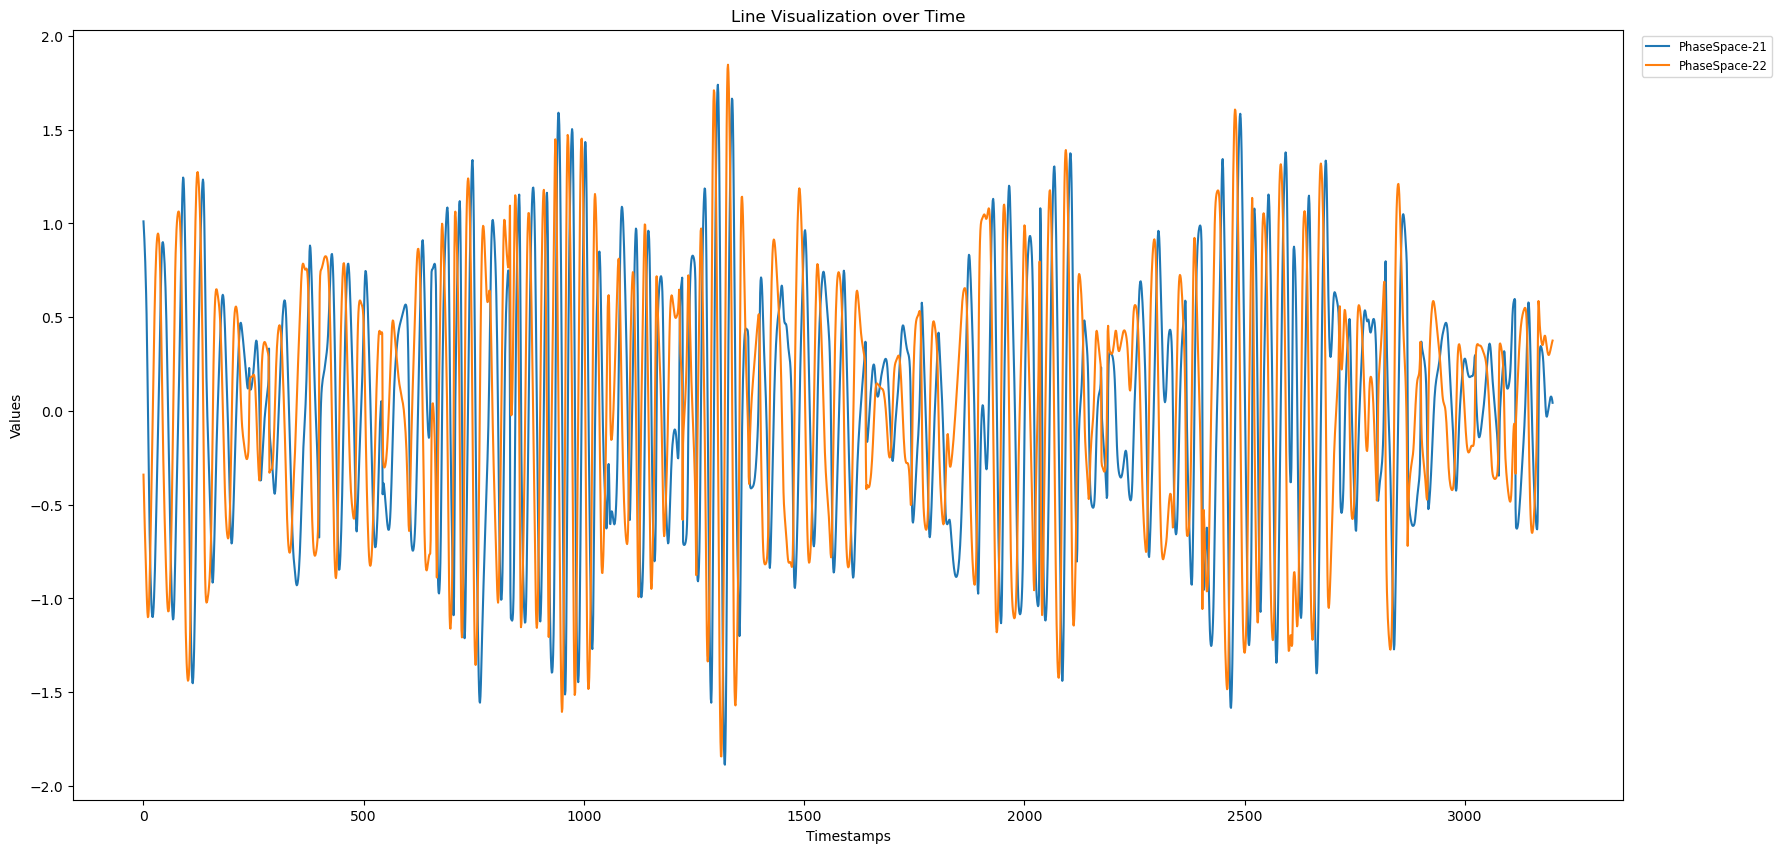

In [85]:
visualize_data(g.cpu().T[20:22], Input_Phase_Labels[20:22])

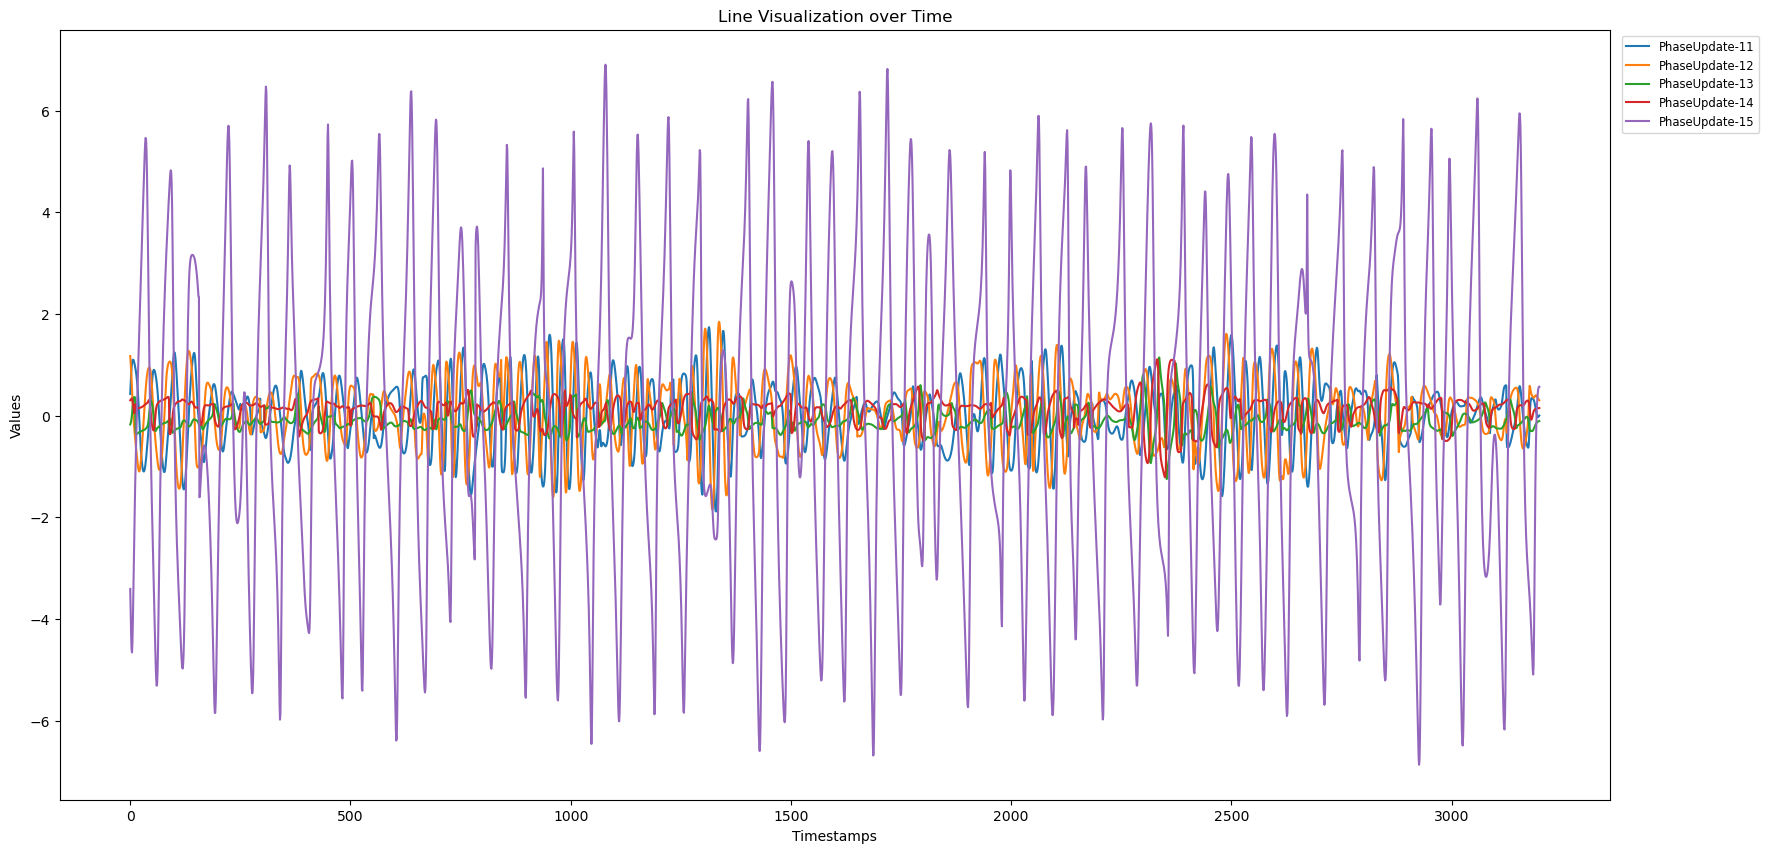

In [91]:
visualize_data(g[:, 10:15].cpu().T, Output_Phase_Labels[10:15])